In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1d_93d9oFNRBK9Vg6BRxs9wvRbKtNTylY',
                                    dest_path='content/pneumonia_dataset.zip',
                                    unzip=True)

Unzipping...Done.


In [ ]:
!nvidia-smi

Sat Jul 17 19:42:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! pip install timm -q
!pip install albumentations==0.4.6

     |████████████████████████████████| 378kB 8.3MB/s 
     |████████████████████████████████| 122kB 8.3MB/s 
     |████████████████████████████████| 952kB 43.8MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65175 sha256=a4341fb5b4f3aa1ab6d1177f3a804d9060e6f33bd4bce559dc469faa69542825
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [3]:
import os
import gc
import random
import pprint
from datetime import datetime

import cv2
import timm
import zipfile
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.cuda.amp import autocast, GradScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

VERBOSE_STEP = 1

In [4]:
def seed_everything(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [5]:
class config:
    n_epochs = 30
    img_size = 256
    arch = "tf_efficientnet_b4_ns"

In [6]:
ROOT_DIR = "/content/content/pneumonia_dataset/"
train_df = pd.DataFrame()


train_df["path"] = list(
    glob(os.path.join(ROOT_DIR, "train","normal", "*")) +
    glob(os.path.join(ROOT_DIR, "train","pneumonia", "*"))
)

train_df["filename"] = train_df["path"].apply(lambda x: os.path.split(x)[-1])
train_df["class"] = train_df["path"].apply(lambda x: os.path.split(os.path.split(x)[0])[-1])
train_df["label"] = train_df["class"].apply(lambda x: 0 if x.lower() == "normal" else 1)

print("Total images:", len(train_df))

Total images: 2425


In [ ]:
os.path.split(os.path.split('/content/content/pneumonia_dataset/train/normal/CXR_train_902.png')[0])

('/content/content/pneumonia_dataset/train', 'normal')

In [7]:
train_df.head(2)

,path,filename,class,label
0,/content/content/pneumonia_dataset/train/norma...,CXR_train_902.png,normal,0
1,/content/content/pneumonia_dataset/train/norma...,CXR_train_2209.png,normal,0


(1024, 1024, 3)


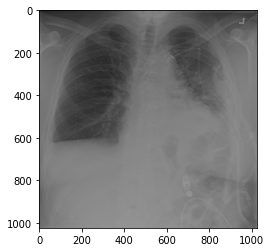

In [13]:
import matplotlib.pyplot as plt
img = cv2.imread(train_df.path.iloc[2])
plt.imshow(img)
print(img.shape)

In [16]:
img.flip(-1)

AttributeError: ignored

In [8]:
class PneumoniaDataset(Dataset):
    def __init__(self, df, data_root, transforms=None, output_label=True):

        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.data_root = data_root
        self.transforms = transforms
        self.output_label = output_label

        if output_label == True:
            self.labels = self.df["label"].values

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index: int):

        if self.output_label:
            target = self.labels[index]

            img = cv2.imread(os.path.join(
                    self.data_root,
                    self.df.loc[index]["class"],
                    self.df.loc[index].filename))[:, :, ::-1]

        else:
            img = cv2.imread(os.path.join(
                    self.data_root,
                    self.df.loc[index].filename))[:, :, ::-1]

        if self.transforms:
            img = self.transforms(image = img)["image"]

        if self.output_label == True:
            return img, target
        else:
            return img

In [9]:
class PneumoniaImageClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)

        if "eff" in model_arch:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, n_class)
        elif "res" in model_arch:
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, n_class)

    def forward(self, x):
        x = self.model(x)
        return x

In [14]:
def get_transforms(split, img_size=512):

    if 'train' in split.lower():
        return A.Compose([
            A.RandomResizedCrop(img_size, img_size, scale=(0.6, 1.0), ratio=(3 / 5, 5 / 3)),
            A.Transpose(p=0.25),
            A.OneOf([
                    A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.8),
                    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.8)
                    ], p=0.5),
            A.OneOf([A.MotionBlur(), A.MedianBlur(blur_limit=3), A.Blur(blur_limit=3)], p=0.2),
            A.HorizontalFlip(p=0.5),
            A.OneOf([
                    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=30, p=0.8),
                    A.Rotate(limit=30, p=0.8)
                    ], p=0.3),
            A.OneOf([A.CLAHE(clip_limit=2), A.IAASharpen(), A.IAAPerspective()], p=0.2),
            A.CoarseDropout(p=0.25),
            A.Cutout(num_holes=8, max_h_size=img_size // 10, max_w_size=img_size // 10, fill_value=0, p=0.25),
            A.Resize(height=img_size, width=img_size, p=1.0),
            A.Normalize(),
            ToTensorV2(p=1.0),
            ], p=1.0)
        
    elif 'valid' in split.lower() or 'test' in split.lower():
        return A.Compose([
            A.Resize(img_size, img_size), 
            A.Normalize(),
            ToTensorV2(p=1.0)
            ], p=1.0)

In [17]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scaler, scheduler=None, schd_batch_update=False):
    model.train()

    running_loss = None

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long() #equiv to int64

        with autocast():
            image_preds = model(imgs)
            loss = loss_fn(image_preds, image_labels)
            scaler.scale(loss).backward()

            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * 0.99 + loss.item() * 0.01

            if ((step + 1) % 2 == 0) or ((step + 1) == len(train_loader)):

                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

                if scheduler is not None and schd_batch_update:
                    scheduler.step()

            if ((step + 1) % VERBOSE_STEP == 0) or ((step + 1) == len(train_loader)):
                description = f"epoch {epoch} loss: {running_loss:.4f}"
                pbar.set_description(description)

    if scheduler is not None and not schd_batch_update:
        scheduler.step()


def valid_one_epoch(epoch, model, loss_fn, val_loader, device, accuracy_fn=None, scheduler=None, schd_loss_update=False):
    model.eval()

    loss_sum = 0
    sample_num = 0
    image_preds_all = []
    image_targets_all = []

    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()

        image_preds = model(imgs)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]

        loss = loss_fn(image_preds, image_labels)

        loss_sum += loss.item() * image_labels.shape[0]
        sample_num += image_labels.shape[0]

        if ((step + 1) % VERBOSE_STEP == 0) or ((step + 1) == len(val_loader)):
            description = f"epoch {epoch} loss: {loss_sum/sample_num:.4f}"
            pbar.set_description(description)

    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)

    if accuracy_fn is not None:
        acc = accuracy_fn(image_targets_all, image_preds_all)
        print(f"validation multi-class accuracy = {acc:.4f}")

    if scheduler is not None:
        if schd_loss_update:
            scheduler.step(loss_sum / sample_num)
        else:
            scheduler.step()


def inference_one_epoch(model, data_loader, device):
    model.eval()
    image_preds_all = []
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()
        image_preds = model(imgs)
        image_preds_flip = model(imgs.flip(-1))
        image_preds = (image_preds + image_preds_flip) / 2
        image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]

    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

In [18]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(np.arange(train_df.shape[0]), train_df.label.values)

In [22]:
for fold, (trn_idx, val_idx) in enumerate(folds):

    print(f"\n\nTRAINING FOLD {fold+1}/5")
    print("Train:", len(trn_idx), "Val:", len(val_idx), "\n")

    train = train_df.loc[trn_idx, :].reset_index(drop=True)
    valid = train_df.loc[val_idx, :].reset_index(drop=True)

    train_dataset = PneumoniaDataset(train, ROOT_DIR+"train/",
        transforms = get_transforms("train", config.img_size), output_label=True)
    valid_dataset = PneumoniaDataset(valid, ROOT_DIR+"train/", 
        transforms = get_transforms("valid", config.img_size), output_label=True)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, num_workers=2,
        pin_memory=False, drop_last=True, shuffle=True)
    val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16*2, num_workers=2,
        pin_memory=False, drop_last=False, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = PneumoniaImageClassifier(config.arch, n_class=2, pretrained=True).to(device)
    scaler = GradScaler()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, total_steps=config.n_epochs)
    loss = torch.nn.CrossEntropyLoss()

    for epoch in range(1, config.n_epochs + 1):        

        train_one_epoch(
            epoch,
            model,
            loss,
            optimizer,
            train_loader,
            device,
            scaler=scaler,
            scheduler=scheduler,
            schd_batch_update=False,
        )

        with torch.no_grad():
            valid_one_epoch(
                epoch,
                model,
                loss,
                val_loader,
                device,
                accuracy_fn=f1_score,
                scheduler=None,
                schd_loss_update=False,
            )

        os.makedirs("./weights/", exist_ok=True)
        
        # save only last epoch
        if epoch >= config.n_epochs:
            torch.save(model.state_dict(), f"./weights/ckpt_{config.arch}_fold_{fold}_{epoch:03d}.pth")

    del model, train_loader, val_loader, scaler, optimizer, scheduler
    torch.cuda.empty_cache(); gc.collect();



TRAINING FOLD 1/5
Train: 1940 Val: 485 



Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_ns-d6313a46.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b4_ns-d6313a46.pth
epoch 1 loss: 0.6459: 100%|██████████| 16/16 [00:09<00:00,  1.66it/s]

validation multi-class accuracy = 0.5736



epoch 2 loss: 0.5908: 100%|██████████| 16/16 [00:09<00:00,  1.76it/s]

validation multi-class accuracy = 0.6697



epoch 3 loss: 0.5649: 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]

validation multi-class accuracy = 0.6911



epoch 4 loss: 0.5943: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]

validation multi-class accuracy = 0.6514



epoch 5 loss: 0.6097: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

validation multi-class accuracy = 0.6901



epoch 6 loss: 0.6057: 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]

validation multi-class accuracy = 0.6843



epoch 7 loss: 0.5910: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]

validation multi-class accuracy = 0.6908



epoch 8 loss: 0.5721: 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

validation multi-class accuracy = 0.7225



epoch 9 loss: 0.5600: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

validation multi-class accuracy = 0.6964



epoch 10 loss: 0.5814: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]

validation multi-class accuracy = 0.6765



epoch 11 loss: 0.5529: 100%|██████████| 16/16 [00:09<00:00,  1.74it/s]

validation multi-class accuracy = 0.6983



epoch 12 loss: 0.5505: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

validation multi-class accuracy = 0.7061



epoch 13 loss: 0.5693: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]

validation multi-class accuracy = 0.6952



epoch 14 loss: 0.5394: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]

validation multi-class accuracy = 0.7228



epoch 15 loss: 0.6141: 100%|██████████| 16/16 [00:09<00:00,  1.66it/s]

validation multi-class accuracy = 0.7237



epoch 16 loss: 0.6159: 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]

validation multi-class accuracy = 0.7190



epoch 17 loss: 0.6337: 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

validation multi-class accuracy = 0.6385



epoch 18 loss: 0.6023: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]

validation multi-class accuracy = 0.6948



epoch 19 loss: 0.5986: 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]

validation multi-class accuracy = 0.6918



epoch 20 loss: 0.6396: 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

validation multi-class accuracy = 0.6793



epoch 21 loss: 0.7830: 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

validation multi-class accuracy = 0.6198



epoch 22 loss: 0.8361: 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

validation multi-class accuracy = 0.6832



epoch 23 loss: 0.8829: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]

validation multi-class accuracy = 0.6091



epoch 24 loss: 0.8702: 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

validation multi-class accuracy = 0.6882



epoch 25 loss: 0.8835: 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

validation multi-class accuracy = 0.6849



epoch 26 loss: 0.8762: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]

validation multi-class accuracy = 0.6744



epoch 27 loss: 0.8902: 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]

validation multi-class accuracy = 0.6804



epoch 28 loss: 0.9343: 100%|██████████| 16/16 [00:09<00:00,  1.68it/s]

validation multi-class accuracy = 0.6906



epoch 29 loss: 0.9251: 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

validation multi-class accuracy = 0.6713



epoch 30 loss: 0.9293: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


validation multi-class accuracy = 0.6757


TRAINING FOLD 2/5
Train: 1940 Val: 485 



epoch 1 loss: 0.6390: 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]

validation multi-class accuracy = 0.6081



epoch 2 loss: 0.5912: 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]

validation multi-class accuracy = 0.7095



epoch 3 loss: 0.5812: 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

validation multi-class accuracy = 0.6911



epoch 4 loss: 0.5691: 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

validation multi-class accuracy = 0.7035



epoch 5 loss: 0.5952: 100%|██████████| 16/16 [00:09<00:00,  1.69it/s]

validation multi-class accuracy = 0.7128



epoch 6 loss: 0.5939: 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

validation multi-class accuracy = 0.7019



epoch 7 loss: 0.5807: 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

validation multi-class accuracy = 0.7090



epoch 8 loss: 0.5939: 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]

validation multi-class accuracy = 0.7300



epoch 9 loss: 0.5641: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]

validation multi-class accuracy = 0.7046



epoch 10 loss: 0.5763: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]

validation multi-class accuracy = 0.7224



epoch 11 loss: 0.5910: 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]

validation multi-class accuracy = 0.7301



epoch 12 loss: 0.5824: 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]

validation multi-class accuracy = 0.6895



epoch 13 loss: 0.5919: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]

validation multi-class accuracy = 0.6895



epoch 14 loss: 0.5782: 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]

validation multi-class accuracy = 0.6989



epoch 15 loss: 0.5992: 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

validation multi-class accuracy = 0.6583



epoch 16 loss: 0.6052: 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

validation multi-class accuracy = 0.6905



epoch 17 loss: 0.6949: 100%|██████████| 16/16 [00:09<00:00,  1.69it/s]

validation multi-class accuracy = 0.6698



epoch 18 loss: 0.5930: 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

validation multi-class accuracy = 0.7046



epoch 19 loss: 0.6469: 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

validation multi-class accuracy = 0.7032



epoch 20 loss: 0.6740: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]

validation multi-class accuracy = 0.7140



epoch 21 loss: 0.6683: 100%|██████████| 16/16 [00:09<00:00,  1.69it/s]

validation multi-class accuracy = 0.7010



epoch 22 loss: 0.7919: 100%|██████████| 16/16 [00:09<00:00,  1.69it/s]

validation multi-class accuracy = 0.7091



epoch 23 loss: 0.7545: 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

validation multi-class accuracy = 0.6774



epoch 24 loss: 0.8204: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]

validation multi-class accuracy = 0.6820



epoch 25 loss: 0.9274: 100%|██████████| 16/16 [00:09<00:00,  1.66it/s]

validation multi-class accuracy = 0.6476



epoch 26 loss: 0.8903: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]

validation multi-class accuracy = 0.6768



epoch 27 loss: 0.9509: 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

validation multi-class accuracy = 0.6883



epoch 28 loss: 0.9245: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

validation multi-class accuracy = 0.6805



epoch 29 loss: 0.9071: 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

validation multi-class accuracy = 0.6695



epoch 30 loss: 0.8930: 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]


validation multi-class accuracy = 0.6667


TRAINING FOLD 3/5
Train: 1940 Val: 485 



epoch 1 loss: 0.6423: 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

validation multi-class accuracy = 0.5751



epoch 2 loss: 0.5880: 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

validation multi-class accuracy = 0.6637



epoch 3 loss: 0.5784: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]

validation multi-class accuracy = 0.7071



epoch 4 loss: 0.5775: 100%|██████████| 16/16 [00:09<00:00,  1.69it/s]

validation multi-class accuracy = 0.7134



epoch 5 loss: 0.5698: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

validation multi-class accuracy = 0.6827



epoch 6 loss: 0.5624: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]

validation multi-class accuracy = 0.6650



epoch 7 loss: 0.5774: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]

validation multi-class accuracy = 0.7013



epoch 8 loss: 0.5613: 100%|██████████| 16/16 [00:09<00:00,  1.66it/s]

validation multi-class accuracy = 0.7066



epoch 9 loss: 0.5683: 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]

validation multi-class accuracy = 0.7027



epoch 10 loss: 0.6032: 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

validation multi-class accuracy = 0.7082



epoch 11 loss: 0.5354: 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

validation multi-class accuracy = 0.6864



epoch 12 loss: 0.5429: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]

validation multi-class accuracy = 0.7127



epoch 13 loss: 0.6251: 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

validation multi-class accuracy = 0.6283



epoch 14 loss: 0.6319: 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

validation multi-class accuracy = 0.6862



epoch 15 loss: 0.6035: 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]

validation multi-class accuracy = 0.6975



epoch 16 loss: 0.6046: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]

validation multi-class accuracy = 0.6859



epoch 17 loss: 0.6463: 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

validation multi-class accuracy = 0.6969



epoch 18 loss: 0.7075: 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

validation multi-class accuracy = 0.6459



epoch 19 loss: 0.6262: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]

validation multi-class accuracy = 0.7052



epoch 20 loss: 0.6618: 100%|██████████| 16/16 [00:09<00:00,  1.68it/s]

validation multi-class accuracy = 0.7064



epoch 21 loss: 0.7152: 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]

validation multi-class accuracy = 0.7229



epoch 22 loss: 0.8139: 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

validation multi-class accuracy = 0.6667



epoch 23 loss: 0.8153: 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]

validation multi-class accuracy = 0.6556



epoch 24 loss: 0.8740: 100%|██████████| 16/16 [00:09<00:00,  1.68it/s]

validation multi-class accuracy = 0.6696



epoch 25 loss: 0.9262: 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]

validation multi-class accuracy = 0.6923



epoch 26 loss: 0.9231: 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

validation multi-class accuracy = 0.6813



epoch 27 loss: 0.9159: 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

validation multi-class accuracy = 0.6886



epoch 28 loss: 0.9390: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

validation multi-class accuracy = 0.6829



epoch 29 loss: 0.9602: 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

validation multi-class accuracy = 0.6886



epoch 30 loss: 0.9553: 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


validation multi-class accuracy = 0.6858


TRAINING FOLD 4/5
Train: 1940 Val: 485 



epoch 1 loss: 0.6497: 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

validation multi-class accuracy = 0.5282



epoch 2 loss: 0.5892: 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

validation multi-class accuracy = 0.6467



epoch 3 loss: 0.5831: 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]

validation multi-class accuracy = 0.6783



epoch 4 loss: 0.6280: 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]

validation multi-class accuracy = 0.5242



epoch 5 loss: 0.6413: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

validation multi-class accuracy = 0.4909



epoch 6 loss: 0.6346: 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

validation multi-class accuracy = 0.5922



epoch 7 loss: 0.5685: 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]

validation multi-class accuracy = 0.6809



epoch 8 loss: 0.5508: 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]

validation multi-class accuracy = 0.6700



epoch 9 loss: 0.5706: 100%|██████████| 16/16 [00:09<00:00,  1.66it/s]

validation multi-class accuracy = 0.6905



epoch 10 loss: 0.6090: 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

validation multi-class accuracy = 0.6667



epoch 11 loss: 0.5689: 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]

validation multi-class accuracy = 0.6478



epoch 12 loss: 0.6663: 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

validation multi-class accuracy = 0.6596



epoch 13 loss: 0.5741: 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]

validation multi-class accuracy = 0.6731



epoch 14 loss: 0.5621: 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

validation multi-class accuracy = 0.7157



epoch 15 loss: 0.6084: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

validation multi-class accuracy = 0.6631



epoch 16 loss: 0.5690: 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

validation multi-class accuracy = 0.7489



epoch 17 loss: 0.6588: 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

validation multi-class accuracy = 0.6910



epoch 18 loss: 0.5557: 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

validation multi-class accuracy = 0.7326



epoch 19 loss: 0.6212: 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]

validation multi-class accuracy = 0.6927



epoch 20 loss: 0.6650: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

validation multi-class accuracy = 0.6718



epoch 21 loss: 0.6360: 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]

validation multi-class accuracy = 0.7265



epoch 22 loss: 0.6628: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

validation multi-class accuracy = 0.6998



epoch 23 loss: 0.6787: 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

validation multi-class accuracy = 0.6866



epoch 24 loss: 0.7759: 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

validation multi-class accuracy = 0.6931



epoch 25 loss: 0.7239: 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]

validation multi-class accuracy = 0.7345



epoch 26 loss: 0.8058: 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]

validation multi-class accuracy = 0.7053



epoch 27 loss: 0.8247: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

validation multi-class accuracy = 0.6998



epoch 28 loss: 0.8518: 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

validation multi-class accuracy = 0.7062



epoch 29 loss: 0.8333: 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]

validation multi-class accuracy = 0.7056



epoch 30 loss: 0.8270: 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]


validation multi-class accuracy = 0.7048


TRAINING FOLD 5/5
Train: 1940 Val: 485 



epoch 1 loss: 0.6445: 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

validation multi-class accuracy = 0.5397



epoch 2 loss: 0.6130: 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

validation multi-class accuracy = 0.6422



epoch 3 loss: 0.5925: 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

validation multi-class accuracy = 0.6729



epoch 4 loss: 0.5919: 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

validation multi-class accuracy = 0.6928



epoch 5 loss: 0.5654: 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]

validation multi-class accuracy = 0.7184



epoch 6 loss: 0.5817: 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

validation multi-class accuracy = 0.6412



epoch 7 loss: 0.5995: 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

validation multi-class accuracy = 0.6162



epoch 8 loss: 0.5954: 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]

validation multi-class accuracy = 0.6810



epoch 9 loss: 0.5818: 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]

validation multi-class accuracy = 0.6553



epoch 10 loss: 0.5560: 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

validation multi-class accuracy = 0.6841



epoch 11 loss: 0.5550: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

validation multi-class accuracy = 0.7322



epoch 12 loss: 0.5712: 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

validation multi-class accuracy = 0.7129



epoch 13 loss: 0.5676: 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

validation multi-class accuracy = 0.6492



epoch 14 loss: 0.5669: 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

validation multi-class accuracy = 0.6780



epoch 15 loss: 0.5563: 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]

validation multi-class accuracy = 0.6445



epoch 16 loss: 0.5922: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

validation multi-class accuracy = 0.6928



epoch 17 loss: 0.6068: 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

validation multi-class accuracy = 0.7069



epoch 18 loss: 0.6484: 100%|██████████| 16/16 [00:09<00:00,  1.66it/s]

validation multi-class accuracy = 0.7133



epoch 19 loss: 0.6049: 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]

validation multi-class accuracy = 0.6861



epoch 20 loss: 0.6439: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

validation multi-class accuracy = 0.6548



epoch 21 loss: 0.6951: 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

validation multi-class accuracy = 0.7064



epoch 22 loss: 0.8497: 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]

validation multi-class accuracy = 0.7002



epoch 23 loss: 0.8343: 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]

validation multi-class accuracy = 0.6805



epoch 24 loss: 0.8762: 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]

validation multi-class accuracy = 0.7031



epoch 25 loss: 0.8440: 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

validation multi-class accuracy = 0.6667



epoch 26 loss: 0.9342: 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]

validation multi-class accuracy = 0.6744



epoch 27 loss: 0.9187: 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]

validation multi-class accuracy = 0.6944



epoch 28 loss: 0.9221: 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

validation multi-class accuracy = 0.7016



epoch 29 loss: 0.9595: 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

validation multi-class accuracy = 0.7080



epoch 30 loss: 0.9712: 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]


validation multi-class accuracy = 0.6957


In [25]:
test_preds = []
test = pd.read_csv(ROOT_DIR + "test.csv")

test_dataset = PneumoniaDataset(test, ROOT_DIR+"test/",
    transforms=get_transforms("test", config.img_size), output_label=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=2,
    pin_memory=False, drop_last=False, shuffle=False)

inference_weights_path = sorted(glob("./weights/*"))
inference_weights = np.ones(len(inference_weights_path))
print("No. of models:", len(inference_weights_path))

for i, model_path in enumerate(inference_weights_path):

    print("\n", i + 1, model_path)
    model_name = model_path.split("ckpt_")[-1].split("fold")[0][:-1]
    model = PneumoniaImageClassifier(model_name, n_class=2).to(device)
    model.load_state_dict(torch.load(model_path))

    with torch.no_grad():
        test_preds += [inference_weights[i]/sum(inference_weights)*inference_one_epoch(model, test_loader, device)]

    del model

torch.cuda.empty_cache(); gc.collect();

No. of models: 5

 1 ./weights/ckpt_tf_efficientnet_b4_ns_fold_0_030.pth


100%|██████████| 19/19 [00:12<00:00,  1.52it/s]



 2 ./weights/ckpt_tf_efficientnet_b4_ns_fold_1_030.pth


100%|██████████| 19/19 [00:13<00:00,  1.42it/s]



 3 ./weights/ckpt_tf_efficientnet_b4_ns_fold_2_030.pth


100%|██████████| 19/19 [00:13<00:00,  1.44it/s]



 4 ./weights/ckpt_tf_efficientnet_b4_ns_fold_3_030.pth


100%|██████████| 19/19 [00:12<00:00,  1.54it/s]



 5 ./weights/ckpt_tf_efficientnet_b4_ns_fold_4_030.pth


100%|██████████| 19/19 [00:12<00:00,  1.54it/s]


In [26]:
inference_weights_path

['./weights/ckpt_tf_efficientnet_b4_ns_fold_0_030.pth',
 './weights/ckpt_tf_efficientnet_b4_ns_fold_1_030.pth',
 './weights/ckpt_tf_efficientnet_b4_ns_fold_2_030.pth',
 './weights/ckpt_tf_efficientnet_b4_ns_fold_3_030.pth',
 './weights/ckpt_tf_efficientnet_b4_ns_fold_4_030.pth']

In [28]:
'./weights/ckpt_tf_efficientnet_b4_ns_fold_0_030.pth'.split("ckpt_")[-1].split("fold")[0][:-1]

'tf_efficientnet_b4_ns'

In [30]:
print("Saving...")
test_preds = np.mean(test_preds, axis=0)

test["proba"] = list(zip(test_preds))
test["class"] = np.argmax(test_preds, axis=1)
test["label"] = test["class"].apply(lambda x: "normal" if int(x) == 0 else "pneumonia")

print(test.shape)
test.head(4)

Saving...
(606, 4)


,filename,proba,class,label
0,CXR_test_519.png,"([0.015404105, 0.18459588],)",1,pneumonia
1,CXR_test_578.png,"([0.14187932, 0.05812068],)",0,normal
2,CXR_test_359.png,"([0.13571468, 0.06428532],)",0,normal
3,CXR_test_573.png,"([0.019217202, 0.18078281],)",1,pneumonia


In [32]:
os.makedirs("./output/", exist_ok=True)
test.to_csv("./output/" + "test.csv", index=False)
test[['filename', 'label']].to_csv("./output/" + "submission.csv", index=False)